*This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20170419_KarplusStrongAlgorithm.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20170419_KarplusStrongAlgorithm.ipynb).*

In this blog post, we will implement the [Karplus-Strong algorithm](https://en.wikipedia.org/wiki/Karplus%E2%80%93Strong_string_synthesis) for guiar sound synthesis. 

# What is the Karplus-Strong algorithm? 

The Karplus-Strong algorithm, named after its two creators, was originally published in 1983 as the following paper ([full paper here](https://users.soe.ucsc.edu/~karplus/papers/digitar.pdf)):

> Karplus, Kevin, and Alex Strong. “Digital Synthesis of Plucked-String and Drum Timbres.” Computer Music Journal 7, no. 2 (1983): 43–55.

As the paper states, it is a simplified digital instrument that allows one to control pitch, amplitude and decay time. What is so interesting about the algorithm is that it yields realistic sounds even though it is very simple.

How does the algorithm work?

To answer that question, we will first go over how wavetable synthesis works.

# Wavetable synthesis 

Wavetable synthesis was invented in the 1970's. It is based on the following idea: suppose you have an array of points describing a wave.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
t = np.linspace(0, 1, num=100)
wavetable = np.sin(np.sin(2 * np.pi * t))

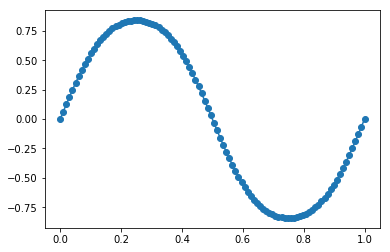

In [3]:
plt.plot(t, wavetable, '-o')

What happens if we imagine a pointer going through our wavetable at different speeds?

In [4]:
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

duration = 2

pointer1 = 1
pointer2 = 2

fig, ax = plt.subplots()
def make_frame(time):
    ax.clear()
    ax.plot(t, wavetable)
    ax.vlines(pointer1 * time / duration, -1, 1, color='red', label='slow pointer')
    ax.vlines(pointer2 * time / duration % 1, -1, 1, color='blue', label='fast pointer')
    for pointer, color in zip([pointer1, pointer2], ['red', 'blue']):
        arg = np.argmin(np.abs(t - (pointer * time / duration % 1)))
        ax.plot(t[arg], wavetable[arg], 'o', color=color)
    ax.set_xlim(0, 1)
    ax.legend(loc='lower left')
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
plt.close(fig)
animation.ipython_display(fps=20, loop=False, autoplay=True)

 98%|████████████████████████████████████████▉ | 40/41 [00:03<00:00, 10.21it/s]


As we can see from the above diagram, the fast pointer goes trough the waveform twice as fast as the original pointer. However, as it reaches the end of the wave, it starts over at the beginning. Using this method, we can easily derive several new waveforms from the original wavetable by looping over the wavetable and going back to the beginning when we reach the beginning.

In [5]:
def synthesize(sampling_speed, wavetable, n_samples):
    """Synthesizes a new waveform from an existing wavetable."""
    samples = []
    current_sample = 0
    while len(samples) < n_samples:
        current_sample += sampling_speed
        current_sample = current_sample % wavetable.size
        samples.append(wavetable[current_sample])
        current_sample += 1
    return np.array(samples)

Let's see what the outputs look like.

In [6]:
sample1 = synthesize(1, wavetable, 300)
sample2 = synthesize(2, wavetable, 300)

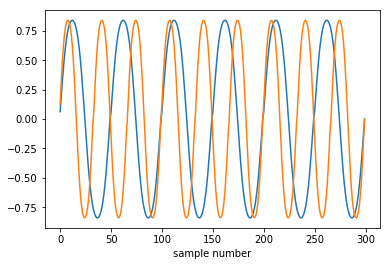

In [7]:
plt.plot(sample1)
plt.plot(sample2)
plt.xlabel('sample number')

What we see is that the waveforms look quite similar except for the fact that one has a higher frequency than the other. Implicitly, this allows to create sounds of different frequencies quite easily.

Let's generate some sounds at interesting frequencies. We first generate a new wavetable designed for a sampling rate of $f_s$ = 8000 Hz.

In [8]:
fs = 8000

In [9]:
t = np.linspace(0, 1, num=fs)
wavetable = np.sin(np.sin(2 * np.pi * t))

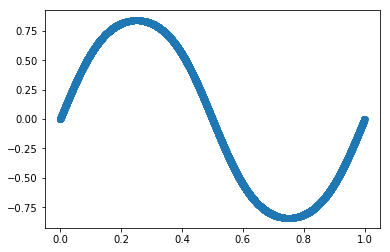

In [10]:
plt.plot(t, wavetable, '-o')

Now, let's generate a sinusoid at 220 Hz and one at 440 Hz.

In [11]:
sample1 = synthesize(220, wavetable, 2 * fs)
sample2 = synthesize(440, wavetable, 2 * fs)

We can listen to it using the IPython rich output:

In [12]:
from IPython.display import Audio

In [13]:
Audio(sample1, rate=fs)

In [14]:
Audio(sample2, rate=fs)

Indeed the sampling scheme works, `sample2` has a higher frequency than `sample1`.

One of the strenghts of this type of wavetable synthesis is that you can easily move to more complex sounds, with harmonics and still use the same model. For instance, we can use a triangle shape:

In [15]:
wavetable = t * (t < 0.5) + (-(t - 1)) * (t>= 0.5)

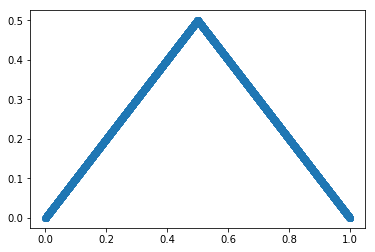

In [16]:
plt.plot(t, wavetable, '-o')

Again, let's sample two sounds:

In [17]:
sample1 = synthesize(220, wavetable, 2 * fs)
sample2 = synthesize(440, wavetable, 2 * fs)

In [18]:
Audio(sample1, rate=fs)

In [19]:
Audio(sample2, rate=fs)

Or, a more complex sine based wavetable.

In [20]:
def make_sine_wavetable(n_samples, amps, phases, freqs):
    """Makes a wavetable from a sum of sines."""
    t = np.linspace(0, 1, num=n_samples)
    wavetable = np.zeros_like(t)
    for amp, phase, freq in zip(amps, 
                                phases,
                                freqs):
        wavetable += amp * np.sin(np.sin(2 * np.pi * freq * t + phase)) + \
                         amp / 2 * np.sin(np.sin(2 * np.pi * 2 * freq * t + phase))
    return wavetable

In [21]:
wavetable = make_sine_wavetable(t.size, [1, 0.4, 0.8, 0.3], 
                            [0, 0.3, 0.4, 0.7],
                            [1, 2, 3, 4])

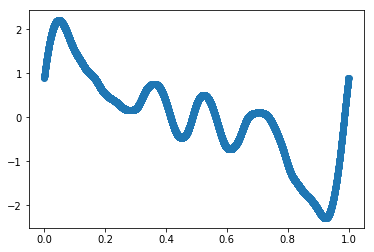

In [22]:
plt.plot(t, wavetable, '-o')

In [23]:
sample1 = synthesize(220, wavetable, 2 * fs)
sample2 = synthesize(440, wavetable, 2 * fs)

In [24]:
Audio(sample1, rate=fs)

In [25]:
Audio(sample2, rate=fs)

Now of course this does not sound like a realistic instrument, for several reasons.

- the wavetable has not the shape of a realistic instrument sound
- there is no dynamic part in the generated sound like attack and decay 

Indeed, if we wanted to, we could use more complex wavetables like this one:

![wavetable](http://synthesizeracademy.com/wp-content/uploads/wavetable-synthesis-wavetable.gif)

And we could also add some an [ADSR (attack, delay, sustain, release) envelope](https://en.wikipedia.org/wiki/Synthesizer#Attack_Decay_Sustain_Release_.28ADSR.29_envelope) to the waveform.


However, we will skip this here and move on to the Karplus-Strong algorithm.

# Changing the wavetable: the Karplus-Strong algorithm 

As explained in the original article:

> The wavetable-synthesis technique is very simple but rather dull musically, since it produces purely periodic tones. Traditional musical instruments produce sounds that vary with time. This variation can be achieved in many ways on computers. The approach in FM synthesis, additive synthesis, subtractive synthesis, and waveshaping is to do further processing of the samples after taking them from the wavetable. All the algorithms described in this paper produce the variation in sound by modifying the wavetable itself. 

In the paper's notation:

$$
Y_t = \frac{1}{2} (Y_{t-p} + Y_{t-p-1})
$$

So, let's modify the wavetable during sampling! The first modification proposed is quite simply to average the last two values in the table. 

Contrary to the wavetable synthesis shown above, we don't keep sample the wavetable at different speeds here. Thus, the length of the wavetable already determines the main frequency of the sound.

In [26]:
def karplus_strong(wavetable, n_samples):
    """Synthesizes a new waveform from an existing wavetable, modifies last sample by averaging."""
    samples = []
    current_sample = 0
    previous_value = 0
    while len(samples) < n_samples:
        wavetable[current_sample] = 0.5 * (wavetable[current_sample] + previous_value)
        samples.append(wavetable[current_sample])
        previous_value = samples[-1]
        current_sample += 1
        current_sample = current_sample % wavetable.size
    return np.array(samples)

Let's try this. The authors recommend to use a wavetable made using a random signal containing either 1s or -1s.

In [27]:
wavetable_size = fs // 220 

wavetable = (2 * np.random.randint(0, 2, wavetable_size) - 1).astype(np.float)

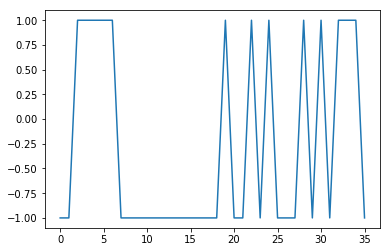

In [28]:
plt.plot(wavetable)

Now, let's synthesize a sound and look at it.

In [29]:
sample1 = karplus_strong(wavetable, 2 * fs)

In [30]:
Audio(sample1, rate=fs)

(0, 1000)

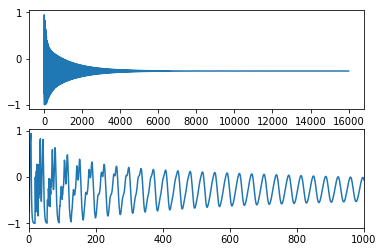

In [31]:
plt.subplot(211)
plt.plot(sample1)
plt.subplot(212)
plt.plot(sample1)
plt.xlim(0, 1000)

Let's do this for a higher frequency:

In [32]:
wavetable_size = fs // 350 

wavetable = (2 * np.random.randint(0, 2, wavetable_size) - 1).astype(np.float)

In [33]:
sample2 = karplus_strong(wavetable, 2 * fs)

In [34]:
Audio(sample2, rate=fs)

In [35]:
sample2 = karplus_strong(wavetable, 2 * fs)

(0, 1000)

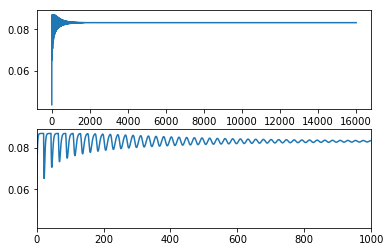

In [36]:
plt.subplot(211)
plt.plot(sample2)
plt.subplot(212)
plt.plot(sample2)
plt.xlim(0, 1000)

Interestingly, this gives very nice physical sounds, as explained in the paper. Also, as can be seen from the waveforms, the initial randomness dies out very quickly, so that we don't really hear it in the synthesized sound.

Let's make some more sounds with this. We will play an A chromatic scale starting at 55 Hz.

In [37]:
from IPython.display import display

In [38]:
freqs = np.logspace(0, 1, num=13, base=2) * 55

In [39]:
for freq in freqs:
    wavetable_size = fs // int(freq)
    wavetable = (2 * np.random.randint(0, 2, wavetable_size) - 1).astype(np.float)
    sample = karplus_strong(wavetable, 1 * fs)
    display(Audio(sample, rate=fs))

Indeed, the sounds are pretty cool!

Let's plot the waveforms as well as the spectrograms of these sounds to better understand what is happening.

In [40]:
waveforms = []
for ind, freq in enumerate(freqs):
    wavetable_size = fs // int(freq)
    wavetable = (2 * np.random.randint(0, 2, wavetable_size) - 1).astype(np.float)
    sample = karplus_strong(wavetable, 2 * fs)
    waveforms.append(sample)

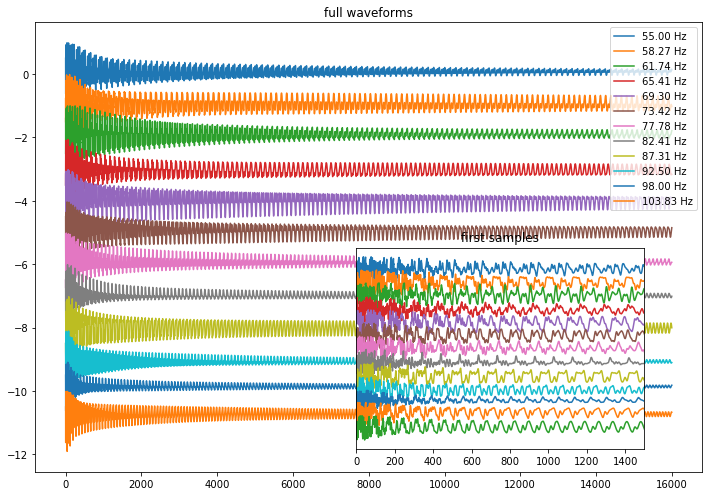

In [41]:
plt.figure(figsize=(10, 7))
for ind, (waveform, freq) in enumerate(zip(waveforms, freqs[:-1])):
    plt.plot(waveform - ind, label='{:.2f} Hz'.format(freq))
plt.legend(loc='upper right')
plt.title('full waveforms')

a = plt.axes([.5, .1, .4, .4], facecolor='white')
plt.yticks([])
for ind, (waveform, freq) in enumerate(zip(waveforms, freqs)):
    plt.plot(waveform - ind, label='{:.2f} Hz'.format(freq))
plt.xlim(0, 1500)
plt.title('first samples')
plt.tight_layout()


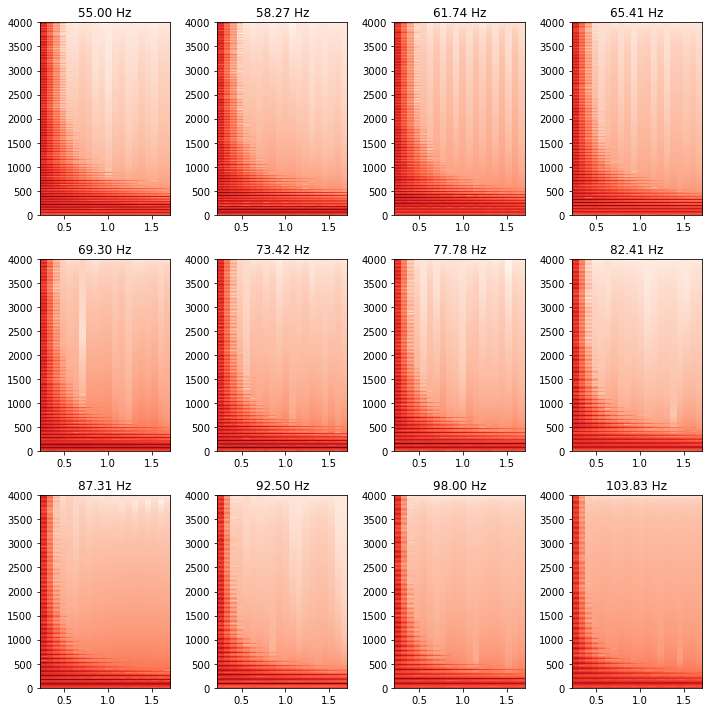

In [42]:
plt.figure(figsize=(10, 10))
for ind, (waveform, freq) in enumerate(zip(waveforms, freqs[:-1])):
    plt.subplot(3, 4, ind+1)
    plt.specgram(waveform, Fs=fs, NFFT=4096, noverlap=3500, cmap='Reds')
    plt.title('{:.2f} Hz'.format(freq))
plt.tight_layout()

We can say several things about the above plots, which are all described in the original paper:

- the algorithm introduces decay, as seen in the time domain plots
- however that decay depends on frequency, as seen in the spectrograms where we see that the higher frequencies die out much more quickly than the low frequencies - this effect is also very well heard in the synthesized sounds
- the sounds are realistic in the sense that they do sound like plucked strings

# The drum algorithm

The original paper describes a very cool variant of the algorithm called the drum algorithm. It involves using a random number to decide whether to change the sign of the new sample.

$$
Y_t = 
\left \{
\begin{array}
+ \frac{1}{2} (Y_{t-p} + Y_{t-p-1}) && \text{probability }b \\ 
- \frac{1}{2} (Y_{t-p} + Y_{t-p-1}) && \text{probability }1-b \\ 
\end{array}
\right.
$$

In [43]:
def karplus_strong_drum(wavetable, n_samples, prob):
    """Synthesizes a new waveform from an existing wavetable, modifies last sample by averaging."""
    samples = []
    current_sample = 0
    previous_value = 0
    while len(samples) < n_samples:
        r = np.random.binomial(1, prob)
        sign = float(r == 1) * 2 - 1
        wavetable[current_sample] = sign * 0.5 * (wavetable[current_sample] + previous_value)
        samples.append(wavetable[current_sample])
        previous_value = samples[-1]
        current_sample += 1
        current_sample = current_sample % wavetable.size
    return np.array(samples)

Let's test this. This time, the recommend wavetable is full of ones.

In [44]:
wavetable_size = fs // 40 
wavetable = np.ones(wavetable_size)

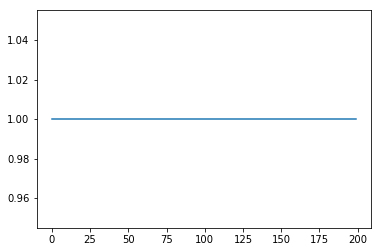

In [45]:
plt.plot(wavetable)

Now, let's synthesize a sound and look at it.

In [46]:
sample1 = karplus_strong_drum(wavetable, 1 * fs, 0.3)

In [47]:
Audio(sample1, rate=fs)

(0, 1000)

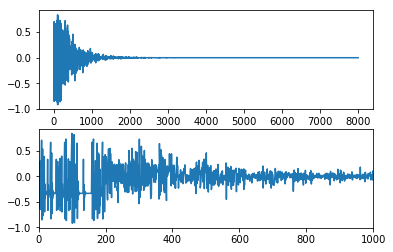

In [48]:
plt.subplot(211)
plt.plot(sample1)
plt.subplot(212)
plt.plot(sample1)
plt.xlim(0, 1000)

This is very interesting, indeed the result sounds like a drum. Let's do a parametric study of this using different values of $b$.

In [49]:
bs = np.arange(0, 1.1, 0.1)

In [50]:
for b in bs:
    wavetable = np.ones(wavetable_size)
    sample = karplus_strong_drum(wavetable, 1 * fs, b)
    display(Audio(sample, rate=fs))

Again, we can replicate the findings by the paper:

- a value of $b = 0$ shows a behaviour of its own
- intermediate values of $b$ around 0.5 sound like drums
- $b=1$ recovers a plucked string sound

Let's explore some more values of $b=0$, with different pitches. We can observe a variety of sounds.

In [51]:
fs = 20000
for freq in [20, 55, 110, 220, 440, 880, 1288]:
    wavetable_size = fs // freq 
    wavetable = np.ones(wavetable_size)
    sample = karplus_strong_drum(wavetable, 2 * fs, 0)
    display(Audio(sample, rate=fs))

# Modifying the algorithm for longer delays 

A last modification is obtained to get longer delays.

In [52]:
def karplus_strong_decay(wavetable, n_samples, stretch_factor):
    """Synthesizes a new waveform from an existing wavetable, modifies last sample by averaging.
    Uses a stretch_factor to control for decay."""
    samples = []
    current_sample = 0
    previous_value = 0
    while len(samples) < n_samples:
        r = np.random.binomial(1, 1 - 1/stretch_factor)
        if r == 0:
            wavetable[current_sample] =  0.5 * (wavetable[current_sample] + previous_value)
        samples.append(wavetable[current_sample])
        previous_value = samples[-1]
        current_sample += 1
        current_sample = current_sample % wavetable.size
    return np.array(samples)

What the stretch_factor does is to keep the initial waveform longer unmodified.

In [53]:
fs = 8000

In [54]:
stretch_factors = [1, 2.1, 3.5, 4, 8]

In [55]:
freq = 220

In [56]:
waveforms = []
for ind, stretch_factor in enumerate(stretch_factors):
    wavetable_size = fs // int(freq)
    wavetable = (2 * np.random.randint(0, 2, wavetable_size) - 1).astype(np.float)
    sample = karplus_strong_decay(wavetable, 2 * fs, stretch_factor)
    waveforms.append(sample)

In [57]:
for waveform in waveforms:
    display(Audio(waveform, rate=fs))

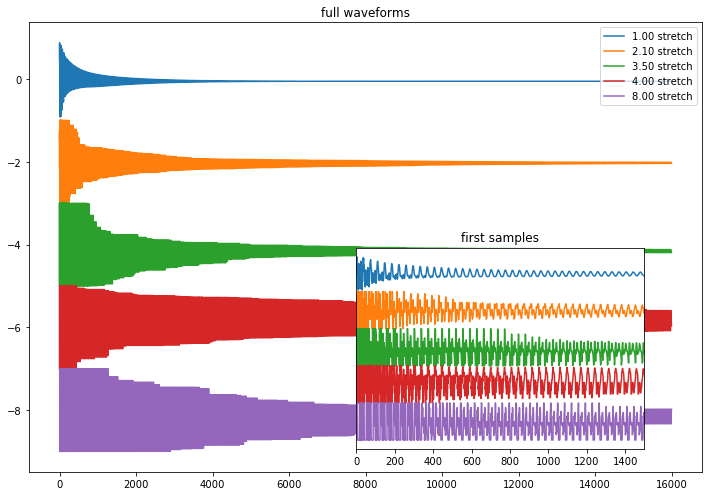

In [58]:
plt.figure(figsize=(10, 7))
for ind, (waveform, stretch_factor) in enumerate(zip(waveforms, stretch_factors)):
    plt.plot(waveform - 2 * ind, label='{:.2f} stretch'.format(stretch_factor))
plt.legend(loc='upper right')
plt.title('full waveforms')

a = plt.axes([.5, .1, .4, .4], facecolor='white')
plt.yticks([])
for ind, (waveform, stretch_factor) in enumerate(zip(waveforms, stretch_factors)):
    plt.plot(waveform - 2 * ind, label='{:.2f} stretch'.format(stretch_factor))
plt.xlim(0, 1500)
plt.title('first samples')
plt.tight_layout()

What we see in the previous plot is that indeed the stretch factor prevents the decay from being to rapid. We can also hear some sort of artifacts in the sounds, which is consistent with the paper explaining that the pitch of the sound is also affected by this algorithm.

The paper mentions that 

> If nonrandom wavetable loads are used with large values of S (long decays), woodwindlike sounds can be produced.

Let's try to achieve just that.

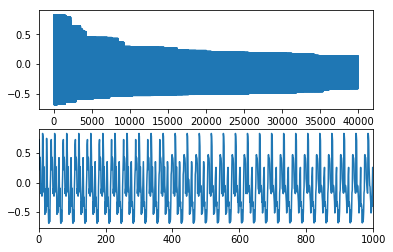

In [59]:
wavetable_size = fs // int(freq)
wavetable = make_sine_wavetable(wavetable_size, [0.3, 0.5, 0.3], [0, 0.5, 0], [1, 3, 9])
sample = karplus_strong_decay(wavetable, 5 * fs, stretch_factor=20)
plt.subplot(211)
plt.plot(sample)
plt.subplot(212)
plt.plot(sample)
plt.xlim(0, 1000)

Audio(sample, rate=fs)

Too bad, even after experimenting, I'm not able to produce woodwindlike sounds!

# Conclusions 

Time for some conclusions. In this post, we replicated a part of the original Karplus-Strong paper. To do so, we made a detour through wavetable synthesis, then implemented the original algorithm described in the paper, found that it indeed produces physically interesting sounds and then also implemented the drum algorithm as well as the sound stretch variation of the original algorithm.

It turns out that this exploration was worthwhile since it allowed us to replicate some results from the original paper, which is definitely worth reading and playing with sounds in the Jupyter notebook. However, there are a lot of open directions from here:

- The original paper describes the math behind the frequency dependent decay that is observed. Why is the decay stronger for higher frequency?
- Subsequent studies related the algorithm to an approximate solution of the wave equation: what is the link between the two?
- How does one deal with fractional frequencies in this algorithm: investigate the role of interpolation to do this.


Also, before I forget, this post was heavily inspired by this Princeton intro to CS assignemnet: <http://introcs.cs.princeton.edu/java/assignments/guitar.html>.
